In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import math
import random
import datetime
import seaborn as sn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Data preprocessing parameters
n_classes = 6 # Number of trainable classes
elements_len = 200 # Number of elements per window
elements_offset = 50 # Offset for next window
train_ratio = 70; # Percentage of elements in training data
rndGeneration = False # Randomize position of training/test elements before LSTM execution

In [3]:
# Neural network parameters
epochs = 30 # Epochs in Neural Network
n_hidden = 30 # Number of hidden layers
batch_size = 10 # Batch size for training

In [4]:
# Activities Labels
Activity = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

In [6]:
# Open Database
projectpath = os.path.dirname(os.getcwd())
datapath = projectpath + "\\Database\\UCI_HAR_Dataset"
dataname = "MainDatabase.csv"

In [7]:
# Load data as matrix (last column labels)
data = pd.read_csv(datapath + "\\" + dataname,sep=',')
sensor_names = data.columns
data_M = data.values
data

,body_acc_x,body_acc_y,body_acc_z,body_gyro_x,body_gyro_y,body_gyro_z,total_acc_x,total_acc_y,total_acc_z,Activity
0,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859,1.012817,-0.123217,0.102934,5
1,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316,1.022833,-0.126876,0.105687,5
2,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250,1.022028,-0.124004,0.102102,5
3,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751,1.017877,-0.124928,0.106553,5
4,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553,1.023680,-0.125767,0.102814,5
...,...,...,...,...,...,...,...,...,...,...
684731,-0.061667,-0.175584,0.151117,0.148295,-0.015923,0.109040,0.908386,-0.423054,-0.092933,2
684732,-0.070890,-0.145071,0.181814,0.143136,-0.024389,0.006547,0.898984,-0.392272,-0.063138,2
684733,-0.050755,-0.104717,0.173271,0.095931,-0.021024,-0.051342,0.918862,-0.351680,-0.072539,2
684734,-0.019807,-0.020764,0.195638,0.090708,-0.041893,-0.078877,0.949475,-0.267526,-0.050975,2


In [8]:
# Creating List timeseries by Activity
act_list = []
datasensor = []
num_sensor = data_M.shape[1]
datasensor.append(data_M[0,0:num_sensor]) # Sensors value for first timeserie (t=0)
prev_label = data_M[0,num_sensor-1] # Last column has activity label
for i in range(1,len(data_M)):
    label = data_M[i,num_sensor-1]
    if (label == prev_label):
        datasensor.append(data_M[i,0:num_sensor])
    else:
        act_list.append(np.vstack(datasensor)) # Convert vectors in datasensor to array and saves in act_list
        datasensor = []
        datasensor.append(data_M[i,0:num_sensor])
    prev_label = label
act_list.append(np.vstack(datasensor))

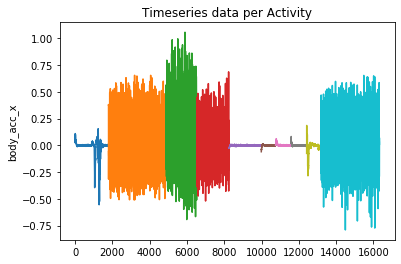

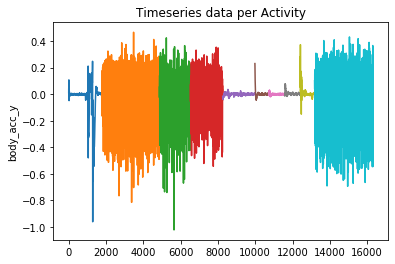

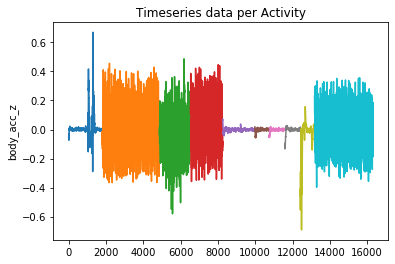

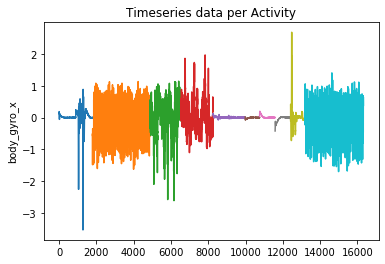

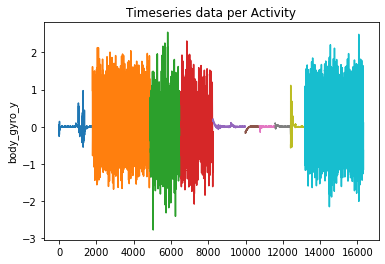

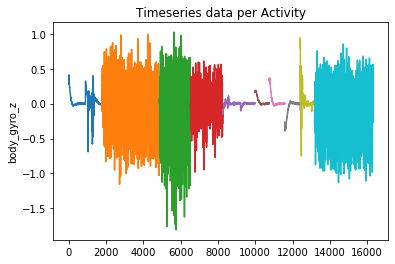

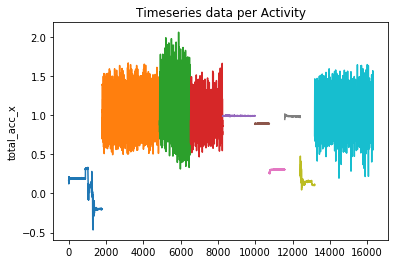

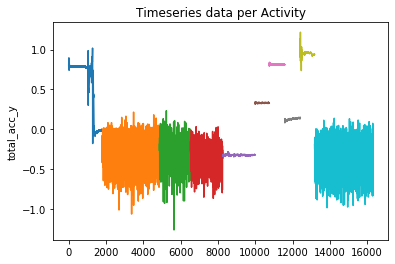

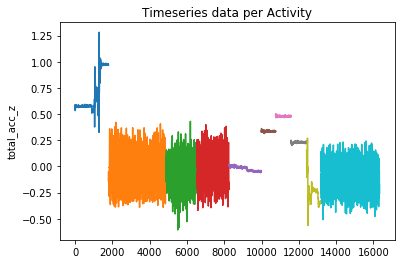

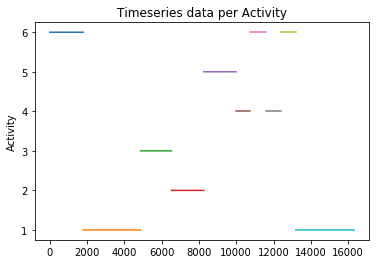

In [9]:
# Timeseries plot per Activity (only for visualization)
N = 12
acc = 0
for j in range(0,num_sensor):
    plt.figure(j)
    acc = 0
    for i in range(2,N):
        pp, = plt.plot(acc + np.arange(0,len(act_list[i])),act_list[i][:,j])
        acc = len(act_list[i]) + acc
    plt.title('Timeseries data per Activity')
    plt.ylabel(sensor_names[j])
init = len(act_list[i])
last = acc + len(act_list[i])

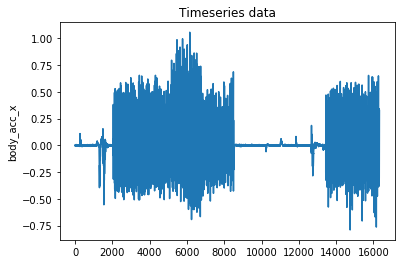

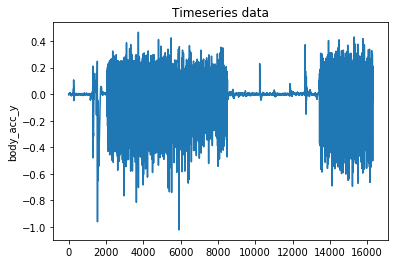

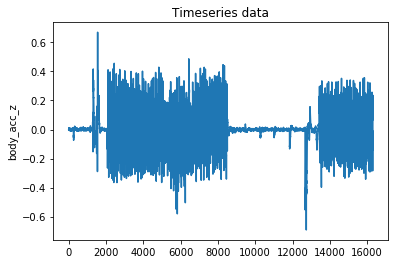

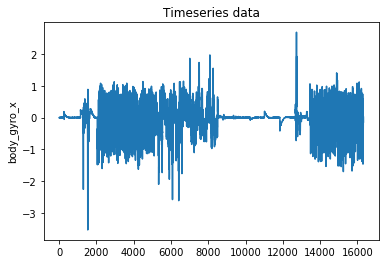

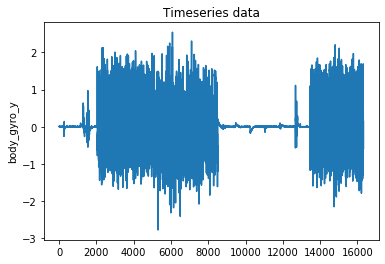

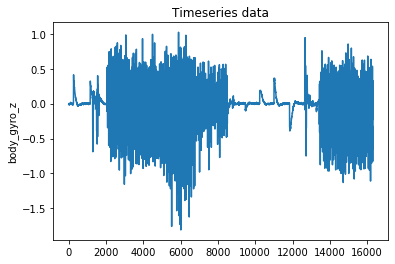

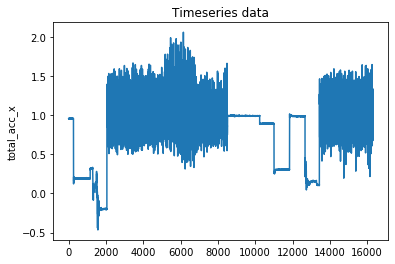

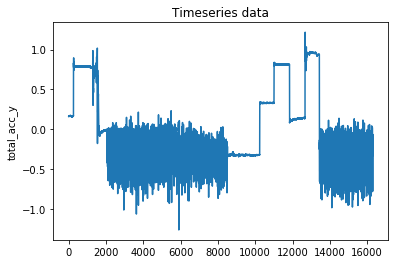

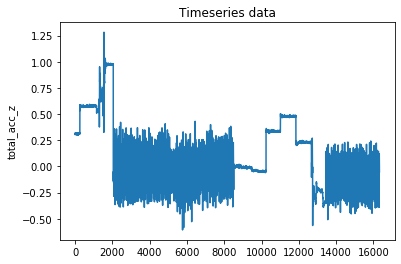

In [10]:
# Timeseries sensor values
for k in range(0,num_sensor-1):
    plt.figure(k)
    plt.plot(data_M[init:last,k])
    plt.title('Timeseries data')
    plt.ylabel(sensor_names[k])

In [11]:
# Dividing each element in activity list to a shorter version
elements = []
for i in range(0,len(act_list)):
    num_elements = math.floor((len(act_list[i])-elements_len)/elements_offset+1) # Number of elements with complete timeseries
    for j in range(0,num_elements):
        start = elements_offset*j
        end = start + elements_len
        elements.append(act_list[i][start:end,0:num_sensor])

In [12]:
# Training and Test Data Generation
tt_list = elements.copy()
train_len = round(train_ratio*len(tt_list)/100)

# Randomize elements if rndGeneration = True
if (rndGeneration):
    random_list = random.sample(tt_list,len(tt_list))
    tt_list = random_list.copy()

# Data train Generation
datatrain = np.stack(tt_list[0:train_len]) # From list of arrays to tensor(:,:,:)
datatrain_x = datatrain[:,:,0:num_sensor-1]
datatrain_y = datatrain[:,5,num_sensor-1]

# Data test Generation
datatest = np.stack(tt_list[train_len:len(tt_list)]) # From list of arrays to tensor(:,:,:)
datatest_x = datatest[:,:,0:num_sensor-1]
datatest_y = datatest[:,5,num_sensor-1]

In [13]:
# Length of data verification #elements = #datatrain + #datatest + #dataval
total_data = len(datatrain)+len(datatest)
print("Length of datatrain:",len(datatrain),"(",round(len(datatrain)/total_data*100,3),"%)")
print("Length of datatest:",len(datatest),"(",round(len(datatest)/total_data*100,3),"%)")
print("Total length:",len(datatrain)+len(datatest))

Length of datatrain: 8614 ( 70.004 %)
Length of datatest: 3691 ( 29.996 %)
Total length: 12305


In [14]:
# Folder for saving data statistics and results
ID = math.floor(random.uniform(0,99999))
result_path = projectpath +"\\Results\\Result_"+str(ID)
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
# Parameters data
parameters_type =  ["Window length","Window offset","Train ratio","rndGeneration","Epoch","Hidden layers","Batch size"]
parameters_data =  [elements_len,elements_offset,train_ratio,rndGeneration,epochs,n_hidden,batch_size]

parameters_fr = pd.DataFrame(parameters_data)
parameters_fr.index = parameters_type
parameters_fr.to_csv(result_path+"\\Parameters.csv")

In [15]:
# Data Statistics
# Table
num_train = np.zeros(len(Activity))
num_test = np.zeros(len(Activity))

for i in range(0,len(Activity)):
    num_train[i] = sum(datatrain_y==i+1)
    num_test[i] = sum(datatest_y==i+1)

num_total = num_train + num_test
num_table = pd.DataFrame([num_train,num_test,num_total])
num_table.columns = Activity
num_table.index = ["Train","Test","Total"]
num_table.to_csv(result_path+"\\ActivityTable.csv")
num_table

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
Train,1438.0,1221.0,1109.0,1513.0,1664.0,1669.0
Test,632.0,590.0,515.0,626.0,641.0,687.0
Total,2070.0,1811.0,1624.0,2139.0,2305.0,2356.0


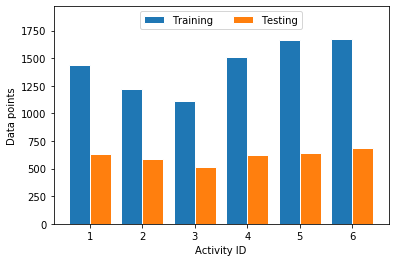

In [16]:
# Data Statistics
# Bar Graphic
train_labels = datatrain_y.reshape(-1) # Total data train histogram
test_labels = datatest_y.reshape(-1) # Total data train histogram
data_labels = [train_labels,test_labels] # Total data histogram
plt.figure(1)
N = plt.hist(data_labels,bins=np.arange(0,7)+0.5,edgecolor='white',label=["Training","Testing"])
plt.xlabel('Activity ID')
plt.ylabel('Data points')
plt.ylim([0,max(N[0][0])+300])
plt.legend(loc='upper center', ncol=3)
plt.savefig(result_path+"\\DataStatistics.png")
plt.show()

In [17]:
# Converting training, test and validation data to one-hot format 
datatrain_y_h = pd.get_dummies(datatrain_y).values
datatest_y_h = pd.get_dummies(datatest_y).values

In [18]:
# Initializing parameters
timesteps = len(datatrain_x[0])
input_dim = len(datatrain_x[0][0])

In [19]:
# Model Construction
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=False))
#model.add(LSTM(n_hidden))
#model.add(Dense(n_hidden))
# Adding a dropout layer
model.add(Dropout(0.1))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Save summary in results folder
with open(result_path + '\\report.txt','w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                4800      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 186       
Total params: 4,986
Trainable params: 4,986
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compiling model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [21]:
# Training the model
model_out = model.fit(datatrain_x,datatrain_y_h,batch_size=batch_size,
                      validation_data=(datatest_x, datatest_y_h),epochs=epochs)

Train on 8614 samples, validate on 3691 samples
Epoch 1/30
8614/8614 [==============================] - 13s 2ms/sample - loss: 1.1816 - accuracy: 0.4963 - val_loss: 1.1948 - val_accuracy: 0.5118
Epoch 2/30
8614/8614 [==============================] - 8s 951us/sample - loss: 0.7920 - accuracy: 0.6830 - val_loss: 0.8401 - val_accuracy: 0.7288
Epoch 3/30
8614/8614 [==============================] - 8s 952us/sample - loss: 0.6223 - accuracy: 0.7941 - val_loss: 0.6745 - val_accuracy: 0.8101
Epoch 4/30
8614/8614 [==============================] - 8s 946us/sample - loss: 0.4207 - accuracy: 0.8616 - val_loss: 0.7288 - val_accuracy: 0.7345
Epoch 5/30
8614/8614 [==============================] - 8s 963us/sample - loss: 0.3415 - accuracy: 0.8865 - val_loss: 0.4442 - val_accuracy: 0.8667
Epoch 6/30
8614/8614 [==============================] - 9s 993us/sample - loss: 0.2941 - accuracy: 0.9064 - val_loss: 0.4551 - val_accuracy: 0.8784
Epoch 7/30
8614/8614 [==============================] - 8s 980us/

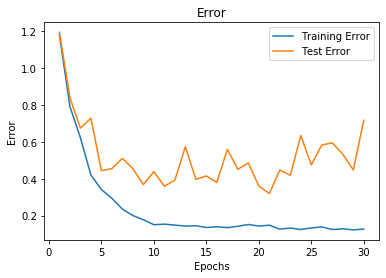

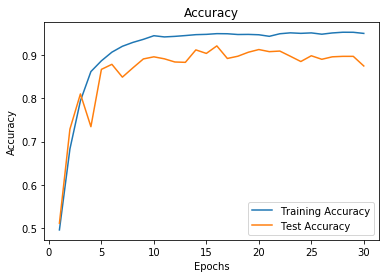

In [22]:
# Error and Accuracy over epochs (Tranning and Test)

# Error
train_err = model_out.history['loss']
test_err = model_out.history['val_loss']
# Plot Error
plt.plot(range(1,len(train_err)+1), train_err, label = 'Training Error')
plt.plot(range(1,len(train_err)+1), test_err, label = 'Test Error')
plt.legend()
plt.title("Error")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.savefig(result_path+"\\Error.png")
plt.show();

# Accuracy
train_acc = model_out.history['accuracy']
test_acc = model_out.history['val_accuracy']
# Plot Accuracy
plt.plot(range(1,len(train_acc)+1), train_acc, label = 'Training Accuracy')
plt.plot(range(1,len(train_acc)+1), test_acc, label = 'Test Accuracy')
plt.legend()
plt.title("Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(result_path+"\\Accuracy.png")
plt.show();

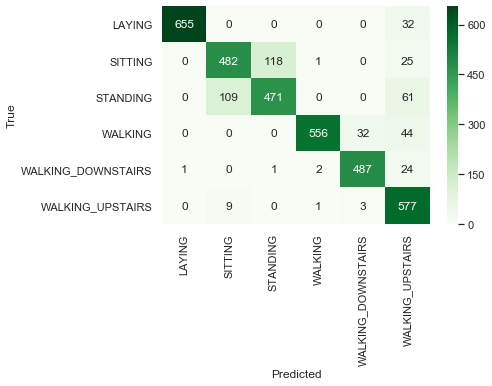

In [23]:
# Confusion Matrix
datapred = model.predict(datatest_x)
Y_true = pd.Series([Activity[y] for y in np.argmax(datatest_y_h, axis=1)])
Y_pred = pd.Series([Activity[y] for y in np.argmax(datapred, axis=1)])
c_matrix = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Predicted'])
sn.set(font_scale=1) # for label size
sn.heatmap(c_matrix, annot=True,cmap="Greens",fmt='g')
plt.savefig(result_path+"\\CMatrix.png",bbox_inches="tight")

In [24]:
# Rename folder according accuracy and error
last_acc = int(test_acc[len(test_acc)-1]*100000)
last_err = int(test_err[len(test_err)-1]*100000)
new_path = projectpath +"\\Results\\Result_A_"+str(last_acc)+"_E_"+str(last_err)
print(result_path)
print(new_path)
os.rename(result_path,new_path)

E:\NCSU\Classes\2019 Fall\ECE 592 - Topics in Data Science\Final Project\Results\Result_34214
E:\NCSU\Classes\2019 Fall\ECE 592 - Topics in Data Science\Final Project\Results\Result_A_87455_E_71687
